In [6]:
import os

import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import warnings

warnings.filterwarnings('ignore')

In [82]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 300

In [8]:
np.random.seed(RANDOM_STATE)

# Чтение и скачивание данных 

Необходимо построить модель, которая будет предсказывать общую продолжительность поездок на такси в Нью-Йорке. 

Данные включает информацию о времени доставки, географических координатах, количествах пассажиров и др.

В самом соревновании очень ценны именно дополнительные внешние данные, которыми вы можете поделиться, но мы попробуем построить именно сами модели и сравнить их.

In [9]:
df = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

#weather https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016
weather = pd.read_csv("data/weather.csv")

os.environ['KAGGLE_USERNAME'] = "miracl16"
os.environ['KAGGLE_KEY'] = "****"

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

In [10]:
# Скачиваение дополнительных данных с Kaggle

"""%%bash
cd data/

kaggle datasets download -d oscarleo/new-york-city-taxi-with-osrm -f fastest_routes_train_part_1.csv
kaggle datasets download -d oscarleo/new-york-city-taxi-with-osrm -f fastest_routes_train_part_2.csv

unzip fastest_routes_train_part_1.csv
unzip fastest_routes_train_part_2.csv

rm fastest_routes_train_part_1.csv.zip
rm fastest_routes_train_part_2.csv.zip""";

In [11]:
# Информация о маршрутах из osrm
routes_1 = pd.read_csv('data/fastest_routes_train_part_1.csv')
routes_2 = pd.read_csv('data/fastest_routes_train_part_2.csv')

In [12]:
weather[:3]

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0


In [13]:
test[:3]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


In [14]:
df[:3]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [15]:
df.shape

(1458644, 11)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [17]:
routes_1[:3]

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."


In [18]:
print(routes_1.shape)
print(routes_2.shape)

(700000, 12)
(758643, 12)


# EDA

## Анализ маршрутов train/test

(40.5, 41.0)

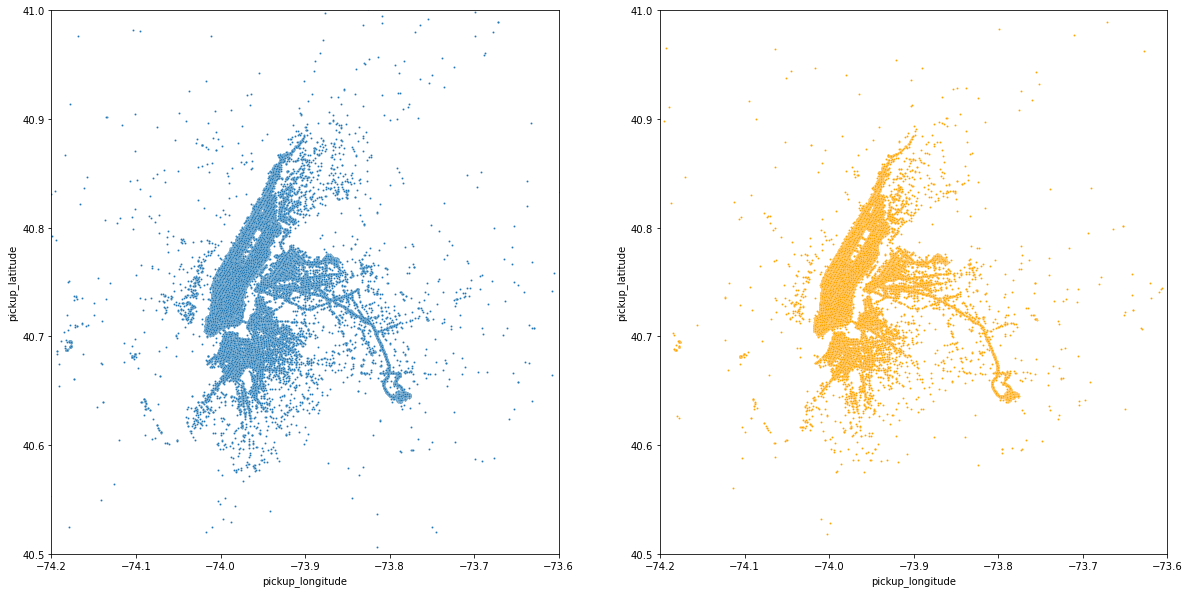

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.scatterplot(df['pickup_longitude'], df['pickup_latitude'], s=4, ax=ax[0])
ax[0].set_xlim([-74.2, -73.6])
ax[0].set_ylim([40.5, 41.0])

sns.scatterplot(test['pickup_longitude'],
                test['pickup_latitude'], s=4, ax=ax[1], color='orange')
ax[1].set_xlim([-74.2, -73.6])
ax[1].set_ylim([40.5, 41.0])


In [20]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000
mean,1.53495,1.66453,-73.97349,40.75092,-73.97342,40.75180,959.49227
std,0.49878,1.31424,0.07090,0.03288,0.07064,0.03589,5237.43172
min,1.00000,0.00000,-121.93334,34.35970,-121.93330,32.18114,1.00000
25%,1.00000,1.00000,-73.99187,40.73735,-73.99133,40.73588,397.00000
50%,2.00000,1.00000,-73.98174,40.75410,-73.97975,40.75452,662.00000
75%,2.00000,2.00000,-73.96733,40.76836,-73.96301,40.76981,1075.00000
max,2.00000,9.00000,-61.33553,51.88108,-61.33553,43.92103,3526282.00000


In [21]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.00000,625134.00000,625134.00000,625134.00000,625134.00000,625134.00000
mean,1.53488,1.66177,-73.97361,40.75093,-73.97346,40.75182
std,0.49878,1.31129,0.07339,0.02985,0.07256,0.03582
min,1.00000,0.00000,-121.93313,37.38959,-121.93333,36.60132
25%,1.00000,1.00000,-73.99185,40.73739,-73.99132,40.73600
50%,2.00000,1.00000,-73.98174,40.75409,-73.97977,40.75454
75%,2.00000,2.00000,-73.96740,40.76839,-73.96301,40.76985
max,2.00000,9.00000,-69.24892,42.81494,-67.49680,48.85760


Обратим в особенности на max и min значения, где то trip_duration = 1 минуте, кол-во пассажиров где то даже 0, макисмально 9, скорее всего это могут быть ошибки в данных, также обратим внимание на долготу и широту, так как нам необходим только город New York, то тогда нужно ограничить пределы по широте и долготе (используем карты)

In [22]:
df[df.pickup_longitude < - 75]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.45592,39.80393,-73.79602,40.70773,N,23440
193116,id2769862,1,2016-02-06 15:43:15,2016-02-06 15:50:12,1,-77.89602,37.77777,-77.89602,37.77777,N,417
233451,id1703300,2,2016-04-26 16:46:00,2016-04-26 16:47:00,1,-77.03944,38.89885,-77.03944,38.89885,N,60
235449,id2298947,2,2016-04-14 15:53:00,2016-04-14 15:54:00,1,-77.03944,38.89885,-77.03944,38.89885,N,60
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.35433,34.71223,-73.83492,32.18114,N,875
595540,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-78.54740,40.81713,-79.78613,40.91764,N,279
646333,id2209294,1,2016-05-22 16:50:00,2016-05-22 16:52:54,1,-75.52462,39.44115,-75.52462,39.44115,N,174
656806,id2344725,2,2016-02-12 12:51:26,2016-02-12 13:02:50,1,-75.24149,41.43066,-75.57015,41.20148,N,684
801241,id3301642,2,2016-05-19 12:53:00,2016-05-19 12:54:00,1,-77.03944,38.89885,-77.03944,38.89885,N,60
952661,id0784573,1,2016-03-28 17:55:13,2016-03-28 18:08:15,2,-77.44075,36.02930,-77.44075,36.02930,N,782


In [23]:
df = df[df.pickup_longitude.between(-75, -71) & df.dropoff_longitude.between(-75, -71)]

In [24]:
test[test.pickup_longitude < - 75]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
152325,id0159022,2,2016-05-16 13:37:00,1,-77.03944,38.89885,-77.03944,38.89885,N
203685,id1455078,2,2016-05-02 09:57:00,1,-77.03944,38.89885,-77.03944,38.89885,N
262912,id1357179,2,2016-04-15 11:47:00,1,-77.03944,38.89885,-77.03944,38.89885,N
308069,id3858705,1,2016-04-02 22:42:19,1,-76.96324,38.94603,-76.96324,38.94603,N
324125,id0505885,2,2016-03-29 14:28:46,2,-121.93313,37.38959,-121.93333,37.38937,N
336944,id1304703,2,2016-03-25 17:21:00,3,-76.99153,38.86469,-76.99153,38.86469,N
344754,id3395374,2,2016-03-23 13:46:00,1,-76.99153,38.86469,-76.99153,38.86469,N
380737,id3233992,1,2016-03-13 04:20:44,3,-79.48790,40.73916,-79.48790,40.73916,N
483163,id1850697,1,2016-02-13 16:37:27,1,-77.59821,42.81494,-77.59821,42.81494,N


## Feature engineering

Найдем для начала расстояние в метрх haversine (от точки до точки по прямой с учетом формы Земли)

In [25]:
# параллельные вычисления
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [26]:
from math import radians, cos, sin, asin, sqrt


def haversine(data):
    """
    Вычисление расстояния в километрах между двумя точками на Земле
    """
    lon1 = data['pickup_longitude']
    lat1 = data['pickup_latitude']
    lon2 = data['dropoff_longitude']
    lat2 = data['dropoff_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))

    r = 6371
    return c * r

In [27]:
df['distance_geo'] = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                         'dropoff_latitude']].parallel_apply(haversine, axis=1)

In [28]:
weather.describe(include='object')

,date,precipitation,snow fall,snow depth
count,366,366,366,366
unique,366,63,11,10
top,1-1-2016,0,0,0
freq,1,116,179,346


In [29]:
weather.precipitation.unique()

array(['0.00', 'T', '1.80', '0.24', '0.05', '0.01', '2.31', '0.73',
       '0.53', '0.44', '1.01', '0.03', '0.30', '1.22', '0.02', '0.14',
       '0.11', '0.06', '0.29', '0.07', '0.04', '0.38', '0.16', '0.09',
       '0.47', '0.20', '0.61', '0.54', '0.25', '0.18', '1.65', '0.40',
       '0.91', '0.45', '0.22', '0.12', '0.83', '0', '0.49', '0.66',
       '0.08', '0.62', '0.35', '1', '1.09', '1.08', '0.15', '0.32',
       '0.82', '0.31', '0.5', '0.56', '0.68', '0.2', '0.4', '0.23',
       '0.55', '1.11', '1.41', '1.81', '2.2', '0.19', '0.39'],
      dtype=object)

In [30]:
weather.loc[weather['precipitation'] == 'T', 'precipitation'] = '0.00'
weather['precipitation'] = weather['precipitation'].astype(float)

weather.loc[weather['snow fall'] == 'T', 'snow fall'] = '0.00'
weather['snow fall'] = weather['snow fall'].astype(float)

weather.loc[weather['snow depth'] == 'T', 'snow depth'] = '0.00'
weather['snow depth'] = weather['snow depth'].astype(float)

Добавим погодные условия

In [31]:
df['date'] = df.pickup_datetime.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
weather['date'] = weather.date.apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))

df_all = pd.merge(df, weather, how='left', on='date')

In [32]:
df_all[:5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_geo,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455,1.49852,2016-03-14,51,40,45.50000,0.29000,0.00000,0.00000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663,1.80551,2016-06-12,83,62,72.50000,0.00000,0.00000,0.00000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.97903,40.76394,-74.00533,40.71009,N,2124,6.38510,2016-01-19,28,16,22.00000,0.00000,0.00000,0.00000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.71997,-74.01227,40.70672,N,429,1.48550,2016-04-06,48,30,39.00000,0.00000,0.00000,0.00000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97305,40.79321,-73.97292,40.78252,N,435,1.18859,2016-03-26,55,38,46.50000,0.00000,0.00000,0.00000


In [33]:
df_all.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
distance_geo           0
date                   0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

Преобразуем время в новые признаки, которые удобно будет в дальнейшем исследовать

In [34]:
df_all['pickup_datetime'] = pd.to_datetime(df_all['pickup_datetime'])

df_all['pickup_month'] = df_all['pickup_datetime'].apply(lambda x: x.month)
df_all['pickup_day'] = df_all['pickup_datetime'].apply(lambda x: x.day)
df_all['pickup_dayofweek'] = df_all['pickup_datetime'].apply(lambda x: x.dayofweek)
df_all['pickup_hour'] = df_all['pickup_datetime'].apply(lambda x: x.hour)
df_all['pickup_minute'] = df_all['pickup_datetime'].apply(lambda x: x.minute)
df_all['pickup_weekends'] = df_all['pickup_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

df_all['store_and_fwd_flag'] = 1 * (df_all.store_and_fwd_flag.values == 'Y')

In [35]:
df_all.reset_index(drop=True, inplace=True)

In [36]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

df_all['pickup_holiday'] = df_all['date'].isin(holidays)
df_all['pickup_holiday'] = df_all['pickup_holiday'].map(lambda x: 1 if x == True else 0)

df_all['pickup_near_holiday'] = df_all['date'].isin(holidays + timedelta(
    days=1)) | df_all['date'].isin(holidays - timedelta(days=1))
df_all['pickup_near_holiday'] = df_all['pickup_near_holiday'].map(lambda x: 1 if x == True else 0)

Добавим информацию о расстоянии маршрута с учетом дорог

In [37]:
routes = routes_1.append(routes_2)
df_all = pd.merge(df_all, routes[['id', 'total_distance']], on='id', how='left')

In [38]:
test['distance_geo'] = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                             'dropoff_latitude']].parallel_apply(haversine, axis=1)

Теперь посмотри на распределение времени поездки

In [39]:
df_all.trip_duration.describe()

count   1458612.00000
mean        959.46376
std        5237.43217
min           1.00000
25%         397.00000
50%         662.00000
75%        1075.00000
max     3526282.00000
Name: trip_duration, dtype: float64

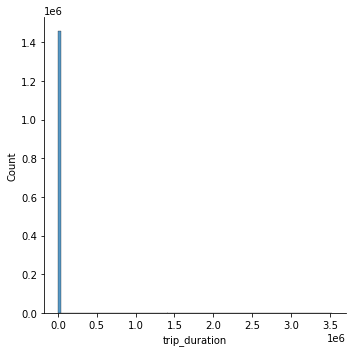

In [40]:
sns.displot(df_all.trip_duration, bins=100);

Видим, что есть выбросы, которые обсуждали ранее, прологорифмируем целевую переменную и добавим значение в датасет

In [41]:
df_all = df_all.assign(log_trip_duration=np.log(df_all.trip_duration + 1))

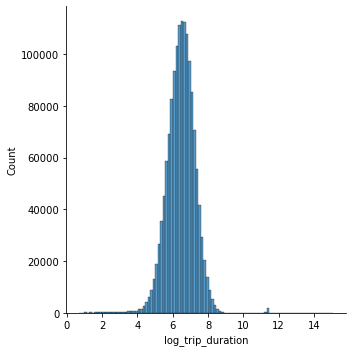

In [42]:
sns.displot(df_all.log_trip_duration, bins=100);

In [43]:
df_all['trip_duration_hour'] = df_all['trip_duration'] / 3600
df_all['total_distance_km'] = df_all['total_distance'] / 1000

df_all['speed_km_h'] = df_all['total_distance_km'] / df_all['trip_duration_hour']

In [44]:
df_all['speed_km_h'].describe()

count   1458611.00000
mean         19.47983
std          25.23001
min           0.00000
25%          12.40946
50%          17.10889
75%          23.50359
max       12428.38286
Name: speed_km_h, dtype: float64

In [45]:
df_all['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

Видим явные выбросы, 12428.38286 - км/ч??, а также скорость = 0

## Обработка выбросов

In [46]:
df_all = df_all[~df_all.passenger_count.isin([0, 7, 8, 9])]
df_all = df_all[df_all['speed_km_h'] != 0]

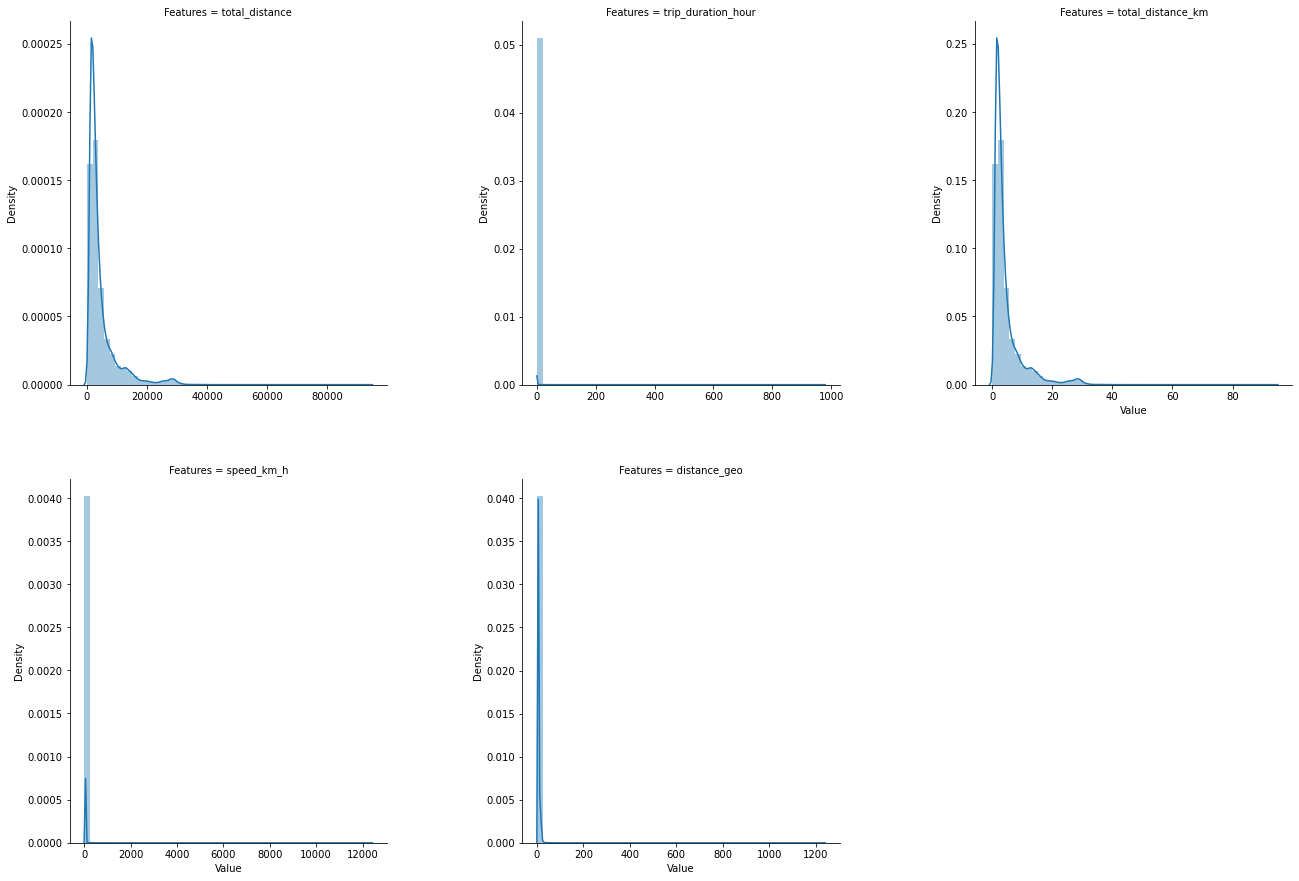

In [47]:
num_cols = ['total_distance', 'trip_duration_hour',
            'total_distance_km', 'speed_km_h', 'distance_geo']

numeric_features = df_all[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                   col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=2, right=2)

In [49]:
for i in num_cols:
    df_all['log_'+i] = np.log(df_all[i]+1)

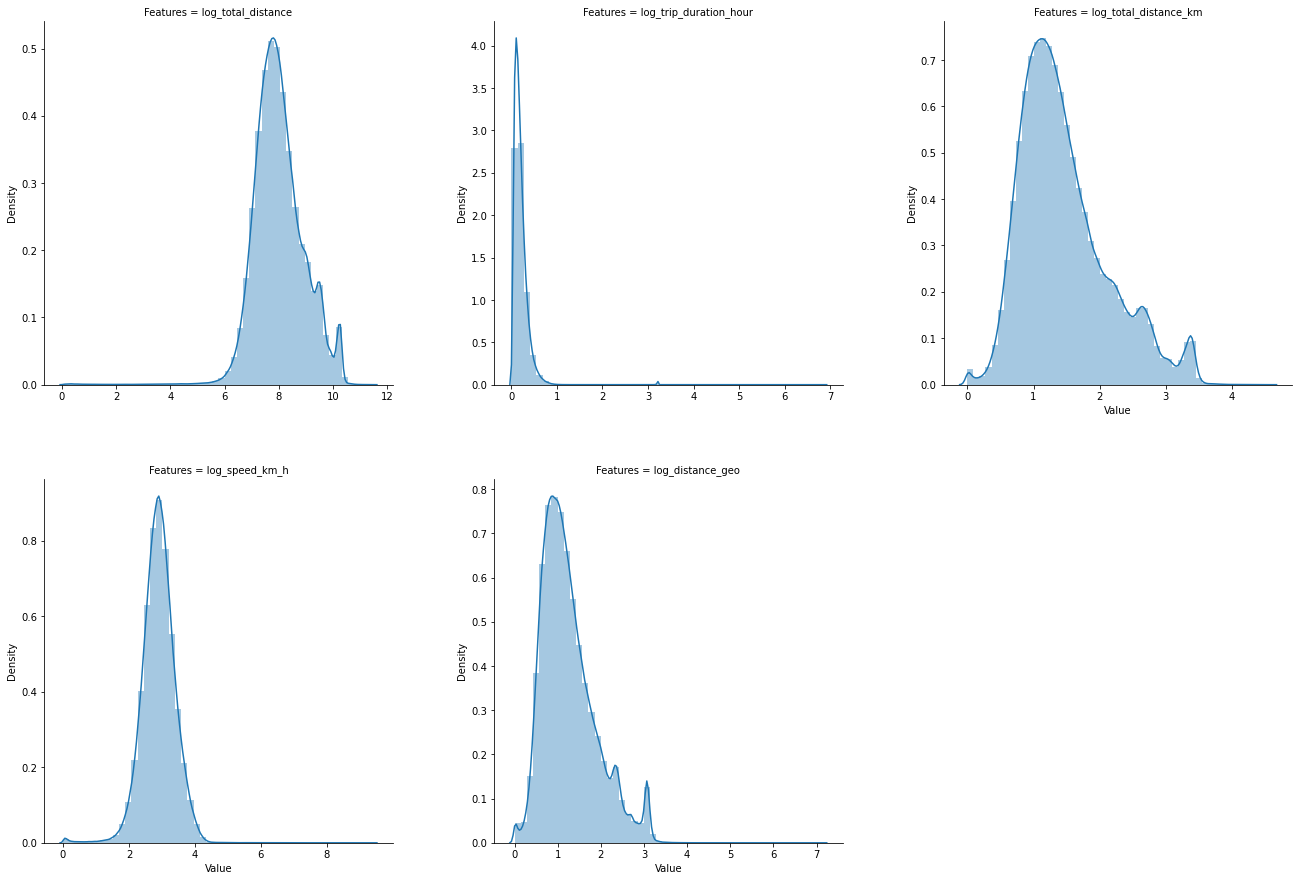

In [50]:
num_cols = [
    'log_total_distance', 'log_trip_duration_hour', 'log_total_distance_km',
    'log_speed_km_h', 'log_distance_geo'
]

numeric_features = df_all[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(columns={
    "level_1": "Features",
    0: "Value"
})

ax = sns.FacetGrid(data=numeric_features,
                   col="Features",
                   col_wrap=3,
                   sharex=False,
                   sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=2, right=2)

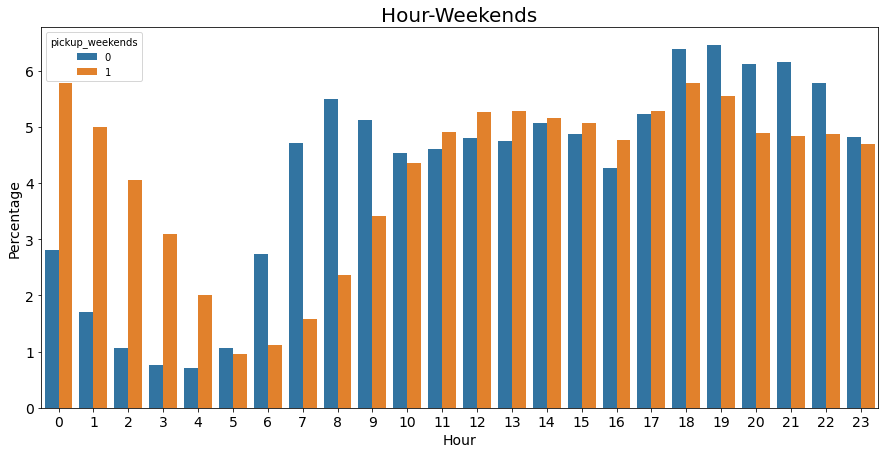

In [51]:
norm_hours = (df_all.groupby(['pickup_weekends'])['pickup_hour']
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index()
              .sort_values('pickup_hour'))

plt.figure(figsize=(15, 7))
ax = sns.barplot(x="pickup_hour", y="percentage", hue="pickup_weekends", data=norm_hours)

plt.title('Hour-Weekends', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

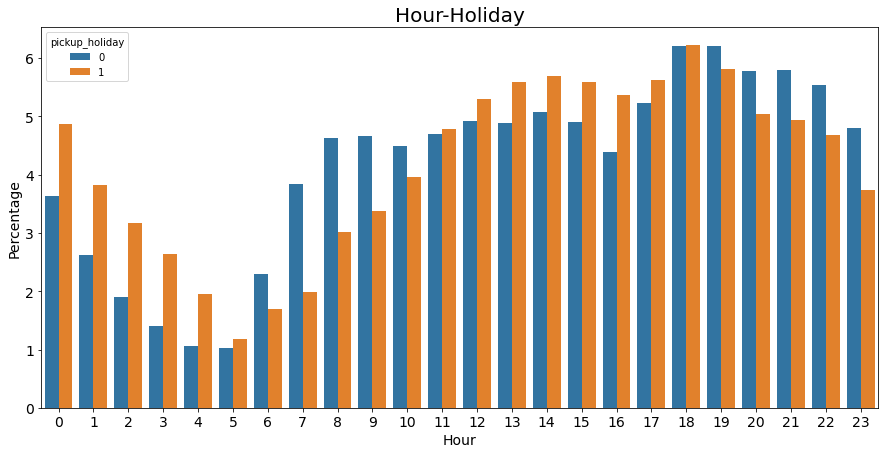

In [52]:
norm_hours = (df_all.groupby(['pickup_holiday'])['pickup_hour']
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index()
              .sort_values('pickup_hour'))

plt.figure(figsize=(15, 7))
ax = sns.barplot(x="pickup_hour", y="percentage", hue="pickup_holiday", data=norm_hours)

plt.title('Hour-Holiday', fontsize=20)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

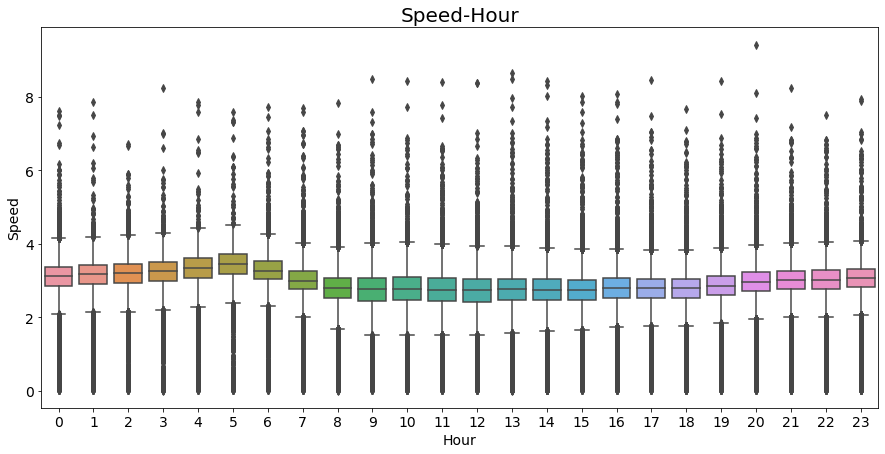

In [53]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_speed_km_h', data=df_all)

plt.title('Speed-Hour', fontsize=20)
plt.ylabel('Speed', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

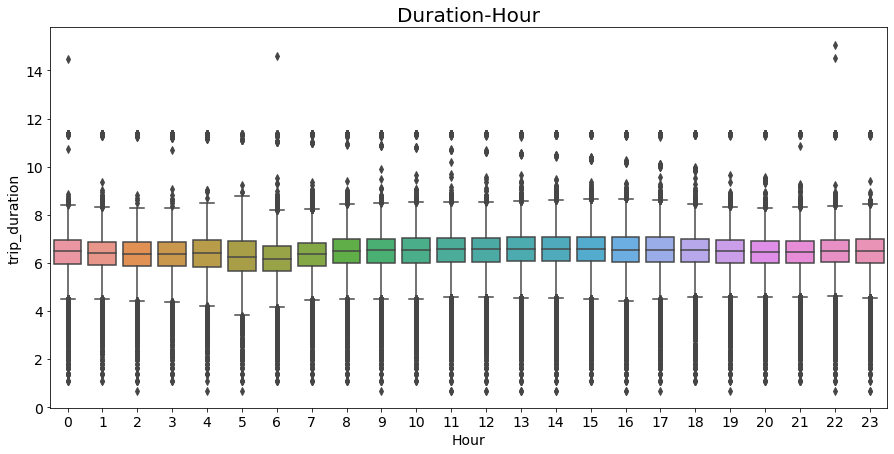

In [54]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_trip_duration', data=df_all)

plt.title('Duration-Hour', fontsize=20)
plt.ylabel('trip_duration', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

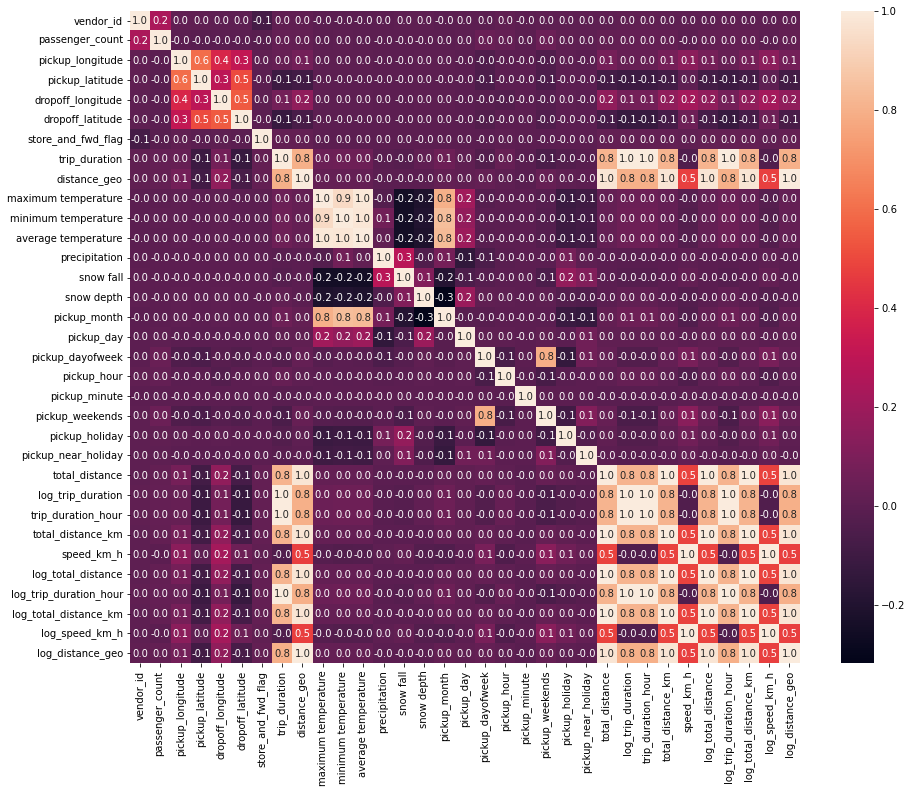

In [55]:
plt.figure(figsize=(15, 12))

sns.heatmap(df_all.corr(method='spearman'), annot=True, fmt=".1f");

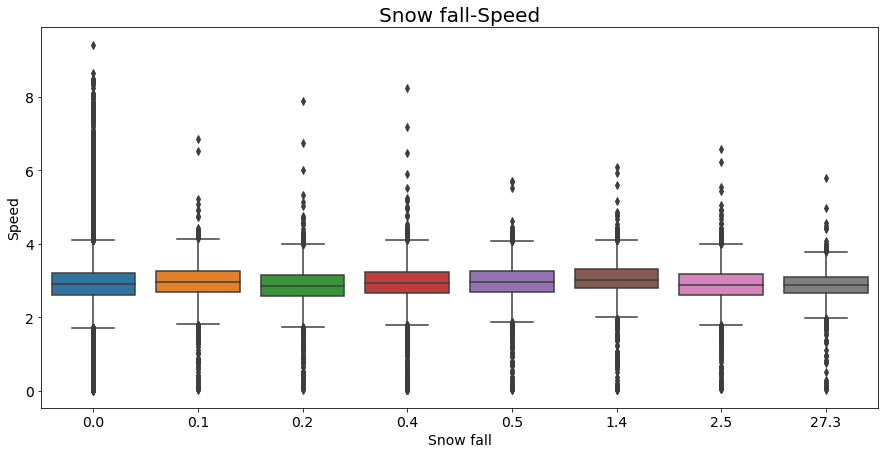

In [56]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='snow fall', y='log_speed_km_h', data=df_all)

plt.title('Snow fall-Speed', fontsize=20)
plt.ylabel('Speed', fontsize=14)
plt.xlabel('Snow fall', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

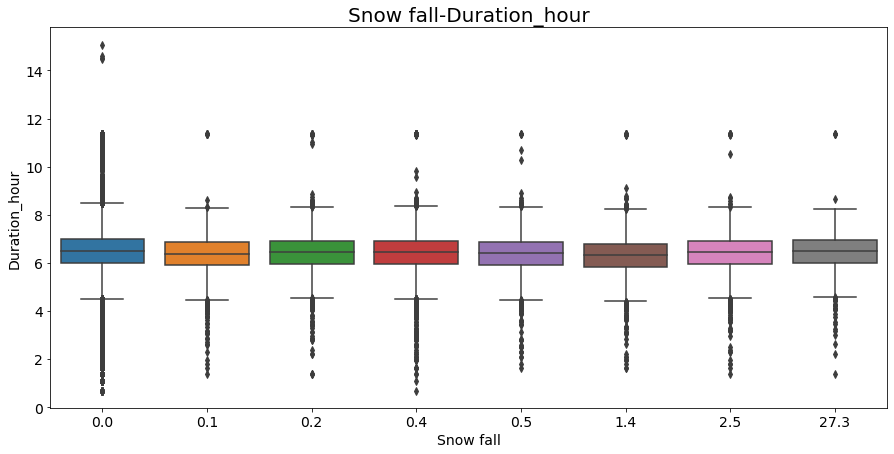

In [57]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='snow fall', y='log_trip_duration', data=df_all)

plt.title('Snow fall-Duration_hour', fontsize=20)
plt.ylabel('Duration_hour', fontsize=14)
plt.xlabel('Snow fall', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

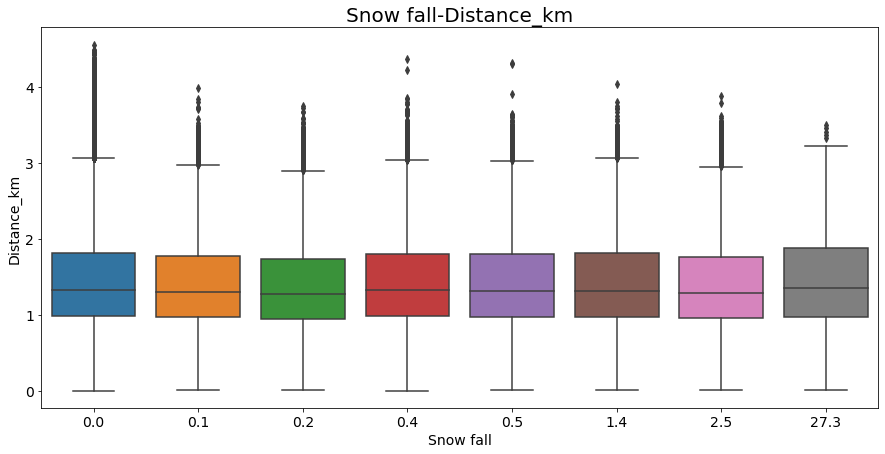

In [58]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='snow fall', y='log_total_distance_km', data=df_all)

plt.title('Snow fall-Distance_km', fontsize=20)
plt.ylabel('Distance_km', fontsize=14)
plt.xlabel('Snow fall', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

# Modeling

## LGBMRegressor + Optuna

In [59]:
import lightgbm as lg

import optuna

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

In [60]:
#df_all.to_pickle('data/all_df.pickle')
#df_all = pd.read_pickle('data/all_df.pickle')

Optuna – фреймворк подбора оптимальных гиперпараметров, который использует байесовский подход для автоматизации пространства поиска гиперпараметров

https://optuna.org

In [61]:
drop_cols_train = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    
    'distance_geo',
    
    'date',
    'total_distance',
    'total_distance_km',
    'log_total_distance_km',
    
    'trip_duration',
    'log_trip_duration',
    'trip_duration_hour',
    'log_trip_duration_hour',
    
    'speed_km_h',
    'log_speed_km_h',
]

In [62]:
X = df_all.drop(columns=drop_cols_train, axis=1)
y = df_all[['log_trip_duration']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [63]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [64]:
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

# целевая функция
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 10, step=2),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200, step=10),
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "l2")
        model = lg.LGBMRegressor(objective="regression", **param_grid)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="rmsle",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=-1)
        preds = model.predict(X_test)        
        cv_predicts[idx] = rmsle(y_test, preds)

    return np.mean(cv_predicts)

callbacks - класс обратного вызова, может обнаруживать бесперспективные наборы гиперпараметров перед обучением, тем самым значительно сокращая время поиска.

In [65]:
study = optuna.create_study(direction="minimize", study_name="LGB")
func = lambda trial: objective(trial, X_train, y_train)
# n_trials - кол-во итераций
study.optimize(func, n_trials=2, show_progress_bar=True)

[I 2022-03-15 02:15:54,411] A new study created in memory with name: LGB


  0%|          | 0/2 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	valid_0's l2: 0.18154
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's l2: 0.181886
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's l2: 0.175277
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	valid_0's l2: 0.175083
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's l2: 0.178364
[I 2022-03-15 02:16:34,121] Trial 0 finished with value: 0.05968013309957726 and parameters: {'n_estimators': 1000, 'learning_rate': 0.08127439137181382, 'num_leaves': 160, 'max_depth': 9, 'min_child_samples': 35}. Best is trial 0 with value: 0.05968013309957726.
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration i

In [66]:
print(f"\tBest value (rmsle): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmsle): 0.05962
	Best params:
		n_estimators: 1000
		learning_rate: 0.03059461559214842
		num_leaves: 210
		max_depth: 5
		min_child_samples: 195


In [67]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.03059461559214842,
 'num_leaves': 210,
 'max_depth': 5,
 'min_child_samples': 195}

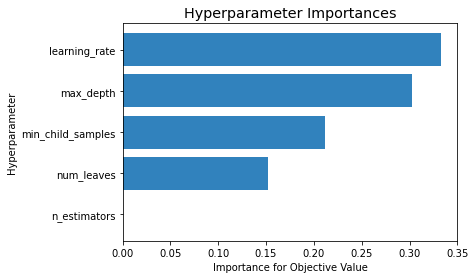

In [68]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

In [69]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

finish_test_preds = []
cv_predicts = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model = lg.LGBMRegressor(objective="regression", **study.best_params)
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="rmsle",
              early_stopping_rounds=100,
              verbose=-1)
    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1
    
    cv_predicts[idx] = rmsle(y_val_exp, preds_exp)
    preds_test = model.predict(X_test)
    finish_test_preds.append(preds_test)
    
    print(f"id = {idx}", cv_predicts[idx], '\n')

print(np.mean(cv_predicts))

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.181618
id = 0 0.4261666550654068 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.181917
id = 1 0.4265174114549663 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.175547
id = 2 0.4189835184894238 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.175206
id = 3 0.41857643484542245 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.178669
id = 4 0.422692643878214 

0.4225873327466867


In [70]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)
test_pred_exp = np.exp(test_pred.data) - 1

y_test_exp = np.exp(y_test.values) - 1

In [71]:
print(f"OOF score: {np.mean(cv_predicts)}")
print(f"HOLDOUT score: {rmsle(y_test_exp, test_pred_exp)}")

OOF score: 0.4225873327466867
HOLDOUT score: 0.41963429724055135


## LAMA AutoML

In [ ]:
# https://github.com/sberbank-ai-lab/LightAutoML

In [72]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import torch 

torch.set_num_threads(N_THREADS)

In [73]:
drop_cols_auto = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    
    'distance_geo',
    
    'date',
    
    'log_total_distance',
    'total_distance_km',
    'log_total_distance_km',
    
    'trip_duration_hour',
    'trip_duration',
    'log_trip_duration_hour',
    
    'speed_km_h',
    'log_speed_km_h',
]

In [74]:
tr_data, te_data = train_test_split(df_all,
                                    test_size=TEST_SIZE,
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(
    tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (1089426, 37), te_data = (363142, 37)


- **Task** - класс, при помощи него ставим задачу, которую необходимо решить (классиф, регрессия), а также какие метрики использовать

- **roles** - роли, какая колонка отвечает за таргет (обязательно), какие нужно удалить и др параметры

- **TabularAutoML** - класс, структура общей модели

In [75]:
%%time

task = Task('reg', loss='rmsle', metric='rmsle')

CPU times: user 1.59 ms, sys: 454 µs, total: 2.04 ms
Wall time: 1.91 ms


In [76]:
%%time

roles = {
    'target': 'log_trip_duration',
    'drop': drop_cols_auto,
}

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 21 µs


In [83]:
automl = TabularAutoML(task=task,
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={
                           'n_jobs': N_THREADS,
                           'cv': N_FOLDS,
                           'random_state': RANDOM_STATE,
                           'verbose': 1
                       })

In [84]:
%%time

#out-of-fold prediction
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose=1)

[02:28:56] Stdout logging level is INFO.
[02:28:56] Task: reg

[02:28:56] Start automl preset with listed constraints:
[02:28:56] - time: 300.00 seconds
[02:28:56] - CPU: 4 cores
[02:28:56] - memory: 16 GB

[02:28:56] Train data shape: (1089426, 37)

[02:29:00] Layer 1 train process start. Time left 296.27 secs
[02:29:01] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[02:29:05] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0719162498794056
[02:29:05] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[02:29:05] Time left 291.34 secs

[02:29:14] Selector_LightGBM fitting and predicting completed
[02:29:14] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[02:29:41] Time limit exceeded after calculating fold 2

[02:29:41] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.059686087012937636
[02:29:41] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[02:29:41] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1

/opt/anaconda3/lib/python3.8/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)
/opt/anaconda3/lib/python3.8/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)
/opt/anaconda3/lib/python3.8/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)
/opt/anaconda3/lib/python3.8/site-packages/lightautoml/transformers/categorical.py:460: RuntimeWarning: invalid value encountered in true_divide
  folds_prior = (f_sum.sum() - f_sum) / (f_count.sum() - f_count)


Посмотрим на структуру модели

In [85]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.78964 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.08574 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.12463 * (1 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [86]:
oof_pred_exp = np.exp(oof_pred.data[:, 0]) - 1

test_pred = automl.predict(te_data)
test_pred_exp = np.exp(test_pred.data[:, 0]) - 1

In [87]:
print(f"OOF score: {rmsle(tr_data['trip_duration'], oof_pred_exp)}")
print(f"HOLDOUT score: {rmsle(te_data['trip_duration'].values, test_pred_exp)}")

OOF score: 0.42406434926943765
HOLDOUT score: 0.4203592811297264


# Feature importance

## LGB + Optuna

In [88]:
from sklearn.inspection import permutation_importance

In [89]:
r = permutation_importance(model, X_test, y_test, n_repeats=2)

In [90]:
perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()), index=('Score', 'Features'))
perm_df = perm_df.T
perm_df = perm_df.sort_values(ascending=False, by='Score')

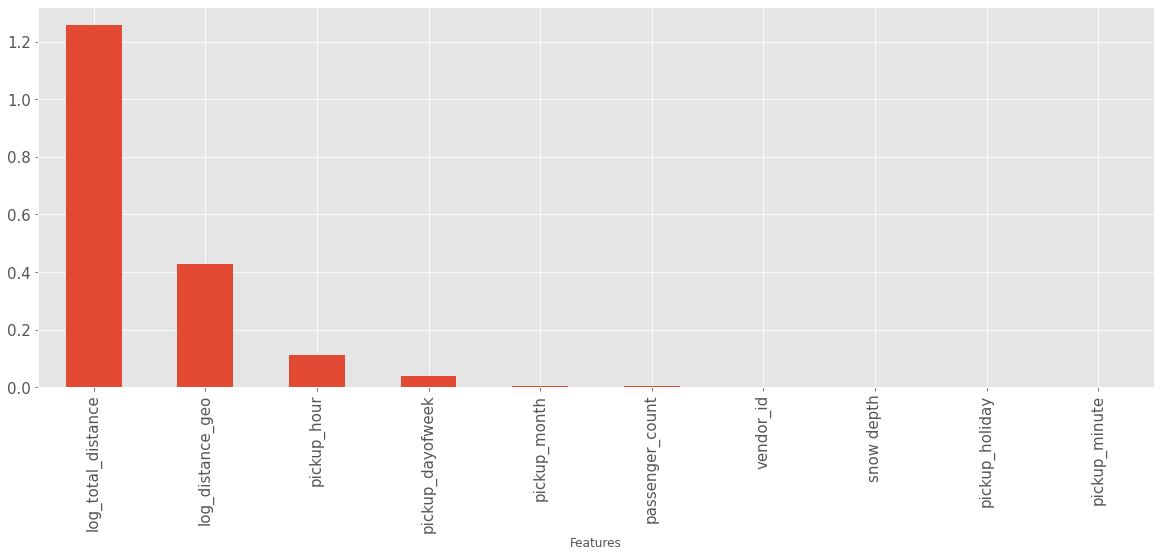

In [91]:
perm_df[:10].set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## LAMA AutoML

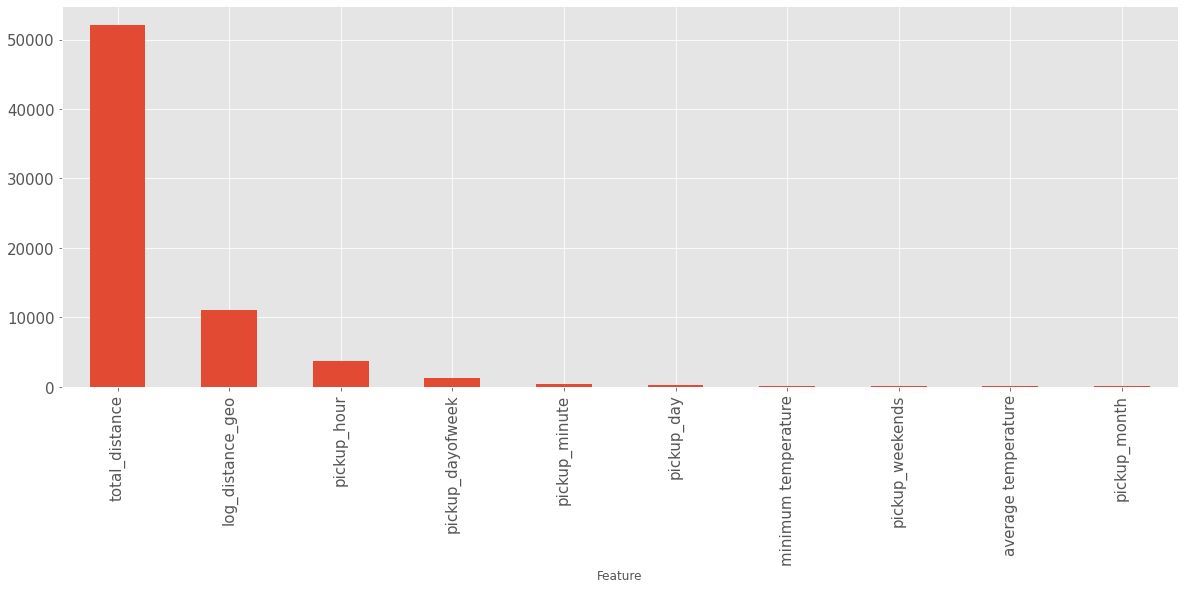

In [92]:
fast_fi = automl.get_feature_scores('fast')
fast_fi[:10].set_index('Feature')['Importance'].plot.bar(figsize = (20, 7), grid = True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
plt.show()